In [46]:
# import the optimized strategy wrote by 3b1b
from wordle.simulations import *


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
df = pd.read_excel("pdata.xlsx")

In [48]:
from scipy.special import softmax

def optimal_guesses(allowed_words, possible_words, priors,
                  look_two_ahead=False,
                  optimize_for_uniform_distribution=False,
                  purely_maximize_information=True,
                  strategy="optimized",
                  max_trial=5,
                  sensitive_priors=None,
                  alpha=0,
                  ):
    if len(possible_words) == 1:
        return [(possible_words[0], 1)]
    if strategy == "entropy-maximization":
        weights = get_weights(possible_words, priors)
        preference = get_entropies(allowed_words, possible_words, weights)
    if strategy == "optimized":
        preference = -get_score_lower_bounds(
            allowed_words, possible_words
        )
    if strategy == "silly-human":
        freqs = get_weights(allowed_words, sensitive_priors)
        weights = get_weights(possible_words, priors)
        ents = get_entropies(allowed_words, possible_words, weights)
        preference = ents ** (1 - alpha) * freqs ** alpha

    trial_times = min(len(possible_words), max_trial)
    top_idx = np.argsort(preference)[-trial_times:]
    guesses = [allowed_words[i] for i in top_idx]
    top_pref = np.array([preference[i] for i in top_idx])
    return list(zip(guesses, softmax(top_pref)))

    # Just experimenting here...
    if optimize_for_uniform_distribution:
        expected_scores = get_score_lower_bounds(
            allowed_words, possible_words
        )
    else:
        expected_scores = get_expected_scores(
            allowed_words, possible_words, priors,
            look_two_ahead=look_two_ahead
        )
    return allowed_words[np.argmin(expected_scores)]

In [70]:
from collections import defaultdict
import pickle 

def simulate_games_DFS(first_guess=None,
                   priors=None,
                   sensitive_priors=None,
                   look_two_ahead=False,
                   optimize_for_uniform_distribution=False,
                   exclude_seen_words=False,
                   test_set=None,
                   shuffle=False,
                   hard_mode=False,
                   purely_maximize_information=True,
                   results_file=None,
                   quiet=False,
                   strategy="optimized",
                   alpha=0,
                   beta=0,
                   ):
    all_words = get_word_list(short=False)
    short_word_list = get_word_list(short=True)

    if priors is None:
        priors = get_frequency_based_priors()

    if test_set is None:
        test_set = short_word_list

    if shuffle:
        random.shuffle(test_set)

    seen = set()
    next_guess_map = {}

    # Function for choosing the next guess, with a dict to cache
    # and reuse results that are seen multiple times in the sim

    def get_next_guesses(possibilities, strategy, phash, sensitive_priors, alpha):
        if phash in next_guess_map:
            return next_guess_map[phash]
        choices = possibilities if hard_mode else all_words
        next_guess_map[phash] = optimal_guesses(
                choices, possibilities, priors,
                strategy=strategy,
                look_two_ahead=look_two_ahead,
                purely_maximize_information=purely_maximize_information,
                optimize_for_uniform_distribution=optimize_for_uniform_distribution,
                sensitive_priors=sensitive_priors,
                alpha=alpha,
            )
        return next_guess_map[phash]
    
    class freq_dist():

        def __init__(self, dist=None) -> None:
            if dist is None:
                self.dist = defaultdict(lambda: 0)
            else:
                self.dist = dist

        def merge(self, other, prob):
            for freq, w in other.dist.items():
                self.dist[freq + 1] += w * prob

    def distribution_prediction(possibilities, strategy="optimized", phash=""):
        dist = freq_dist()
        # print(guesses)
        for guess, prob in get_next_guesses(possibilities, strategy, phash, sensitive_priors, alpha):
            if guess == answer:
                if strategy == "silly-human":
                    dist.merge(freq_dist({0: 1 - beta, 1: beta}), prob)
                else:
                    dist.merge(freq_dist({0: 1}), prob)
                continue
            pattern = get_pattern(guess, answer)
            new_phash = phash + str(guess) + "".join(map(str, pattern_to_int_list(pattern)))
            dist.merge(distribution_prediction(get_possible_words(guess, pattern, possibilities), strategy, new_phash), prob)
        
        return dist

    # Go through each answer in the test set, play the game,
    # and keep track of the stats.

    result = pd.DataFrame(0, index=test_set, columns=[1, 2, 3, 4, 5, 6])
    for answer in ProgressDisplay(test_set, leave=False, desc=" Trying all wordle answers"):
        
        possibilities = list(filter(lambda w: priors[w] > 0, all_words))

        if exclude_seen_words:
            possibilities = list(filter(lambda w: w not in seen, possibilities))
        dist = distribution_prediction(possibilities, strategy).dist
        for k in dist:
            result.loc[answer, min(k, 6)] += dist[k]
    return result
    
    # with open('next_guess_map.pkl', 'wb') as f:
    #     pickle.dump(dictionary, f)
        
    # with open('saved_dictionary.pkl', 'rb') as f:
    #     loaded_dict = pickle.load(f)
        


In [82]:
opt_res = simulate_games_DFS(
        test_set=df["Word"].to_list(),
        priors=get_true_wordle_prior(),
        sensitive_priors=get_frequency_based_priors(width_under_sigmoid=50),
        optimize_for_uniform_distribution=True,
        strategy="optimized",
    )
opt_res.to_excel("opt_res.xlsx")

In [144]:
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

lexdict = dict(pos_tag(opt_res.index, tagset='universal'))
opt_res["lexical_category"] = [lexdict[item] for item in opt_res.index]

def number_of_duplicate_letters(string):
    tmp = set()
    for letter in string:
        tmp.add(letter)
    return len(string) - len(tmp)
freq_map = get_word_frequencies()
opt_res["freq"] = [freq_map[word] for word in opt_res.index]
opt_res["number of duplicate letters"] = [number_of_duplicate_letters(word) for word in opt_res.index]
opt_res.to_excel("opt_res.xlsx")
# opt_res

In [92]:
EM_res = simulate_games_DFS(
        test_set=df["Word"].to_list(),
        priors=get_true_wordle_prior(),
        sensitive_priors=get_frequency_based_priors(width_under_sigmoid=50),
        optimize_for_uniform_distribution=True,
        strategy="entropy-maximization",
    )
EM_res.to_excel("EM_res.xlsx")

Text(0.5, 0, 'Expected number of attempts made before the right word')

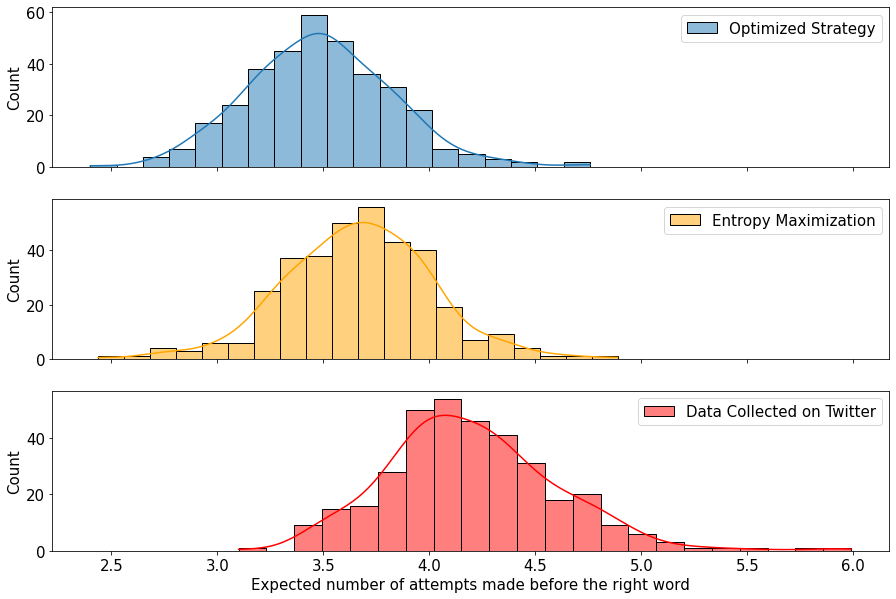

In [108]:
import seaborn as sns
plt.rcParams.update({'font.size': 15})
opt_res["average_trials"] = opt_res[1] + 2 * opt_res[2] + 3 * opt_res[3] + 4 * opt_res[4] + 5 * opt_res[5] + 6 * opt_res[6]
EM_res["average_trials"] = EM_res[1] + 2 * EM_res[2] + 3 * EM_res[3] + 4 * EM_res[4] + 5 * EM_res[5] + 6 * EM_res[6]

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15, 10))
sns.histplot(opt_res["average_trials"], kde=True, label="Optimized Strategy", ax=ax[0])
sns.histplot(EM_res["average_trials"], kde=True, label="Entropy Maximization", ax=ax[1], color="orange")
sns.histplot(df["average"], kde=True, label="Data Collected on Twitter", ax=ax[2], color="red")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[2].set_xlabel("Expected number of attempts made before the right word")
# sns.kdeplot(opt_res["average_trials"])

In [201]:
from scipy.stats import wasserstein_distance
from random import sample
from scipy.optimize import minimize


def calculate_avg(res):
    res["average_trials"] = res[1] + 2 * res[2] + 3 * res[3] + 4 * res[4] + 5 * res[5] + 6 * res[6]

data = pd.read_excel("sdata.xlsx", index_col=0) / 100
calculate_avg(data)


def optfunc(alpha, beta=None, n=30):
    human_res = simulate_games_DFS(
        test_set=df["Word"].to_list()[:n],
        priors=get_true_wordle_prior(),
        sensitive_priors=get_frequency_based_priors(width_under_sigmoid=50),
        optimize_for_uniform_distribution=True,
        strategy="silly-human",
        alpha=alpha,
        beta=0
    )  
    calculate_avg(human_res)
    beta = data["average_trials"].mean() - human_res["average_trials"].mean()
    for i in range(6, 1, -1):
        human_res[i] = human_res[i] * (1 - beta) + human_res[i - 1] * beta
    human_res[1] = human_res[1] * (1 - beta)
    EMDs = []
    for word in human_res.index:
        EMDs.append(wasserstein_distance(range(1, 7), range(1, 7), data.loc[word][:-1], human_res.loc[word][:-1]))
    return np.array(EMDs).mean(), beta




d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Probability')

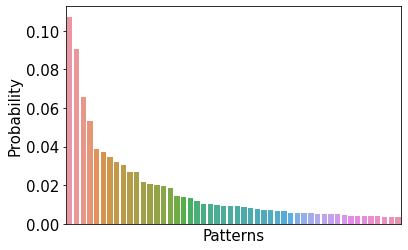

In [129]:
all_words = get_word_list(short=False)
priors = get_frequency_based_priors()
weights = get_weights(all_words, priors)
data = sorted(get_pattern_distributions(["crane"], all_words, weights)[0], reverse=True)
sns.barplot(list(range(50)), data[:50])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel("Patterns")
plt.ylabel("Probability")

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Probability')

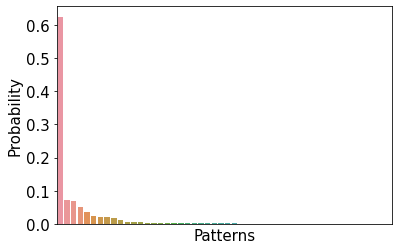

In [135]:
all_words = get_word_list(short=False)
priors = get_frequency_based_priors()
weights = get_weights(all_words, priors)
data = sorted(get_pattern_distributions(["mummy"], all_words, weights)[0], reverse=True)
sns.barplot(list(range(50)), data[:50])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel("Patterns")
plt.ylabel("Probability")

In [257]:
all_words = get_word_list(short=False)
priors = get_frequency_based_priors()
weights = get_weights(all_words, priors)
top_openers = get_entropies(["slate", "train", "feast", "dream", "alien"], all_words, weights)


In [255]:
possibilities = list(filter(lambda w: priors[w] > 0, all_words))
ents = get_entropies(possibilities, all_words, weights)

Text(0.5, 0, 'Expected amount of information get')

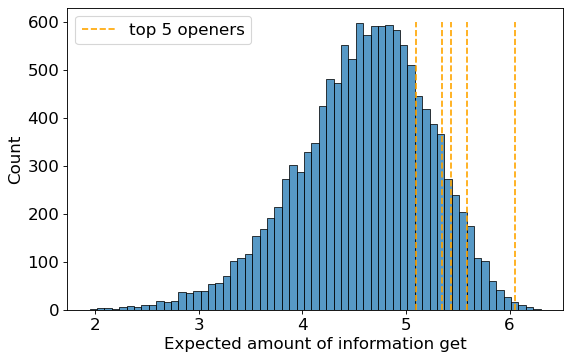

In [263]:
figure(figsize=(8, 5), dpi=80)
sns.histplot(ents)
plt.vlines(top_openers, 0, 600, colors="orange", linestyles="dashed", label="top 5 openers")
plt.legend()
plt.xlabel("Expected amount of information get")

In [214]:
from matplotlib.pyplot import figure
pred_res = simulate_games_DFS(
        test_set=data.index,
        priors=get_true_wordle_prior(),
        sensitive_priors=get_frequency_based_priors(width_under_sigmoid=50),
        optimize_for_uniform_distribution=True,
        strategy="silly-human",
        alpha=0.51,
        beta=0.28
    )
# pred_res.to_excel("eerie.xlsx")
print(pred_res)

         1    2         3         4         5         6
Word                                                   
slump  0.0  0.0  0.201620  0.567989  0.219192  0.011199
crank  0.0  0.0  0.288011  0.543993  0.167996  0.000000
gorge  0.0  0.0  0.115192  0.649605  0.235203  0.000000
query  0.0  0.0  0.143981  0.459206  0.329610  0.067202
drink  0.0  0.0  0.351346  0.499530  0.146884  0.002239
...    ...  ...       ...       ...       ...       ...
condo  0.0  0.0  0.345617  0.497267  0.152635  0.004481
impel  0.0  0.0  0.230462  0.579162  0.190376  0.000000
havoc  0.0  0.0  0.143951  0.608986  0.238102  0.008962
molar  0.0  0.0  0.201578  0.550731  0.229771  0.017921
manly  0.0  0.0  0.086419  0.621126  0.274542  0.017913

[352 rows x 6 columns]


Text(0.5, 0, 'Expected number of attempts made before the right word')

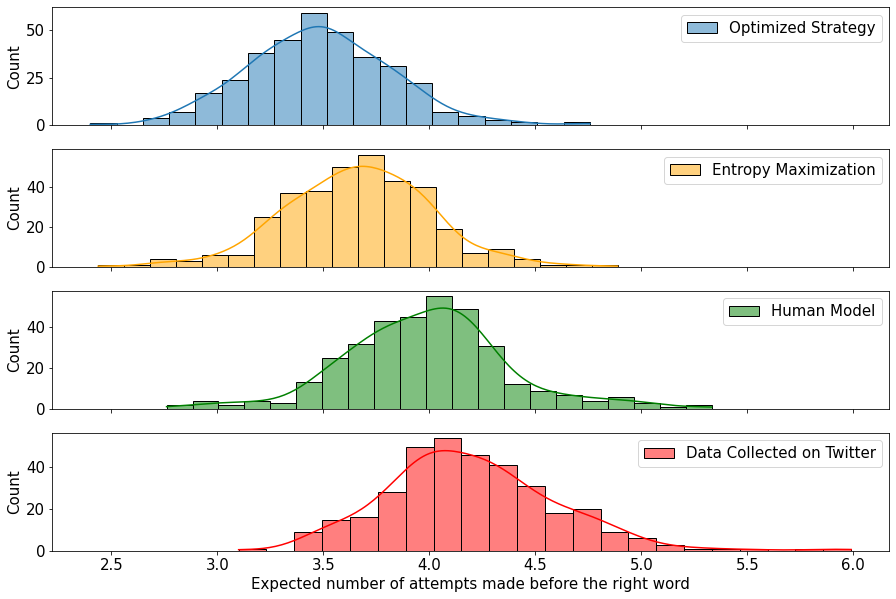

In [217]:
import seaborn as sns
plt.rcParams.update({'font.size': 15})
calculate_avg(EM_res)
calculate_avg(opt_res)
calculate_avg(pred_res)

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(15, 10))
sns.histplot(opt_res["average_trials"], kde=True, label="Optimized Strategy", ax=ax[0])
sns.histplot(EM_res["average_trials"], kde=True, label="Entropy Maximization", ax=ax[1], color="orange")
sns.histplot(pred_res["average_trials"], kde=True, label="Human Model", ax=ax[2], color="green")
sns.histplot(df["average"], kde=True, label="Data Collected on Twitter", ax=ax[3], color="red")

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[3].set_xlabel("Expected number of attempts made before the right word")
# sns.kdeplot(opt_res["average_trials"])

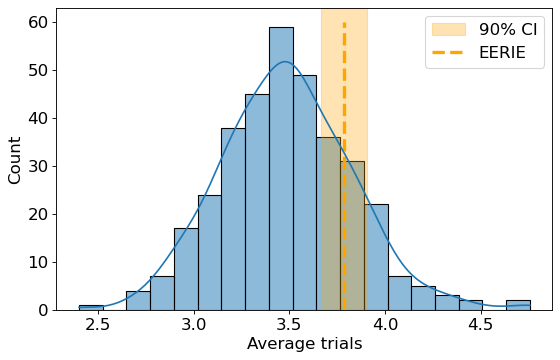

In [253]:

pred_res1 = simulate_games_DFS(
        test_set=["eerie"],
        priors=get_true_wordle_prior(),
        sensitive_priors=get_frequency_based_priors(width_under_sigmoid=50),
        optimize_for_uniform_distribution=True,
        strategy="silly-human",
        alpha=0.51,
        beta=0.28
    )
figure(figsize=(8, 5), dpi=80)
calculate_avg(pred_res1)
sns.histplot(opt_res["average_trials"], kde=True,)
plt.vlines(x=pred_res1["average_trials"]["eerie"], ymax=60, ymin=0, colors="orange", linestyles="dashed", lw=3, label="EERIE")
plt.legend()
plt.xlabel("Average trials")
pred_res1
lb, rb = stats.norm.interval(alpha=0.90,
                 loc=3.783982,
                 scale=errors.std())
plt.axvspan(lb, rb, alpha=0.3, color='orange', label="90% CI")
plt.legend()

In [241]:
errors = df["average"] - list(pred_res["average_trials"])

Text(0.5, 0, 'Error')

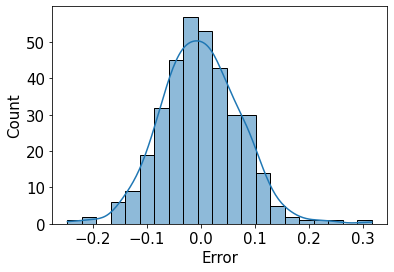

In [242]:
sns.histplot(errors, kde=True)
plt.xlabel("Error")

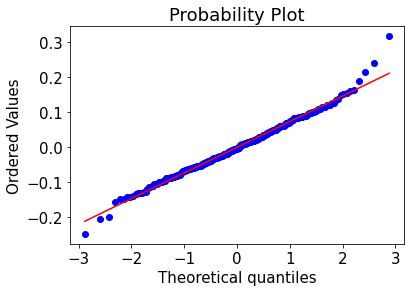

In [243]:
from scipy import stats
import pylab

stats.probplot(errors, dist="norm", plot=pylab)
pylab.show()

In [245]:
stats.shapiro(errors)
errors.std()
stats.norm.interval(alpha=0.90,
                 loc=3.783982,
                 scale=errors.std())

(3.6636789013623026, 3.9042850986376973)

In [239]:
errors.std()

0.36569545358471733